# Content

## Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [2]:
# Install libs
%pip install pandas 
%pip install seaborn 
%pip install matplotlib
%pip install surprise "numpy<2"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, SVD, accuracy, dump
from surprise.model_selection import train_test_split, RandomizedSearchCV

In [4]:
# Load dataset into df_ratings
rating_df = pd.read_csv('../data/rating.csv')
anime_df = pd.read_csv('../data/anime.csv')

anime_df.shape, rating_df.shape

((12294, 7), (7813737, 3))

In [5]:
# Display some data
print(f'Anime Data : ')
display(anime_df.head())

print(f'Rating Data : ')
display(rating_df.head())

Anime Data : 


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Rating Data : 


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
display(anime_df.info()), display(rating_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


None

(None, None)

In [7]:
# Checking if there is any null column
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [8]:
# Drop duplicates
anime_df.drop_duplicates(subset=['name'], inplace=True)
rating_df = rating_df.drop_duplicates().reset_index(drop=True)

In [9]:
# Delete ratings = -1
# -1: The user has not given a rating yet
rating_df = rating_df[rating_df['rating'] != -1]

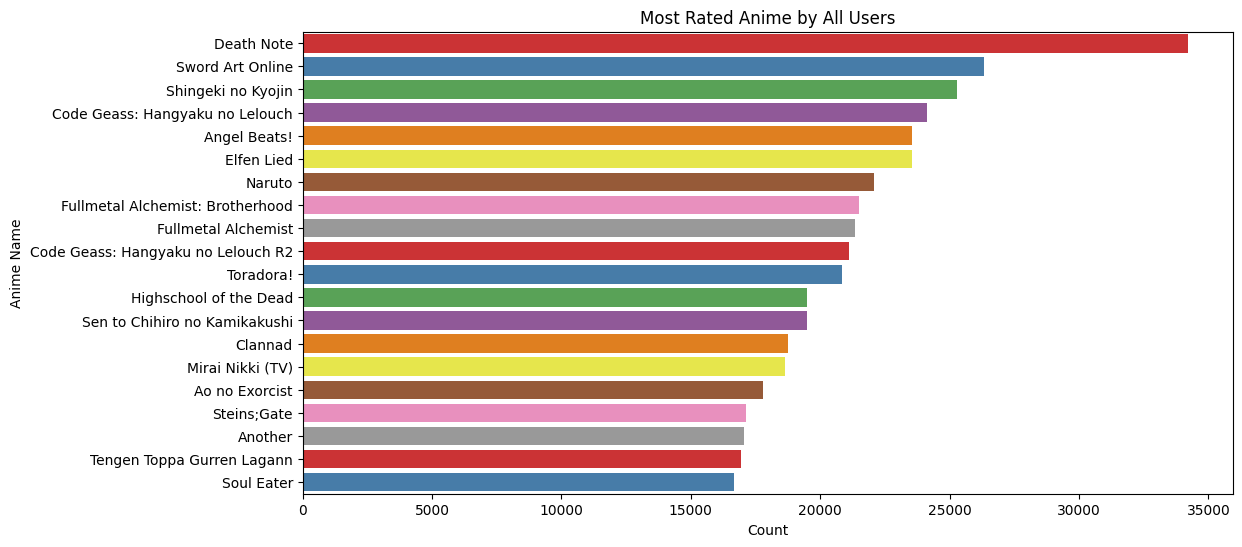

In [10]:
# Show the most rated anime by all users
most_rated_anime = rating_df.groupby(by='anime_id')['user_id'].count()
most_rated_anime_sorted = most_rated_anime.sort_values(ascending=False).head(20)

anime = anime_df[anime_df['anime_id'].isin(most_rated_anime_sorted.index)]
anime_sorted = anime.set_index('anime_id').loc[most_rated_anime_sorted.index].reset_index()

dict = {'name' : anime_sorted['name'],
        'count' : most_rated_anime_sorted.values}
df = pd.DataFrame(data=dict)

plt.figure(figsize=(12,6))
sns.barplot(x = df['count'], y = df['name'], orient='h', hue=df['name'], palette='Set1')
plt.title('Most Rated Anime by All Users')
plt.xlabel('Count')
plt.ylabel('Anime Name')
plt.show()

In [11]:
most_highest_rating_anime = rating_df.groupby(by = 'anime_id')['rating'].mean()

dict = {
    'anime_id' : most_highest_rating_anime.index.tolist(),
    'frequency' : most_rated_anime.values.tolist(),
    'avg_rating' : most_highest_rating_anime.values.tolist()
}

df = pd.DataFrame(dict)

In [12]:
df = df[df['frequency'] >= 100]

df = df.sort_values(by = ['avg_rating', 'frequency'], ascending=False).head(20)
df = pd.merge(left = anime_df[['anime_id', 'name']], right = df, how = 'right', on = 'anime_id')

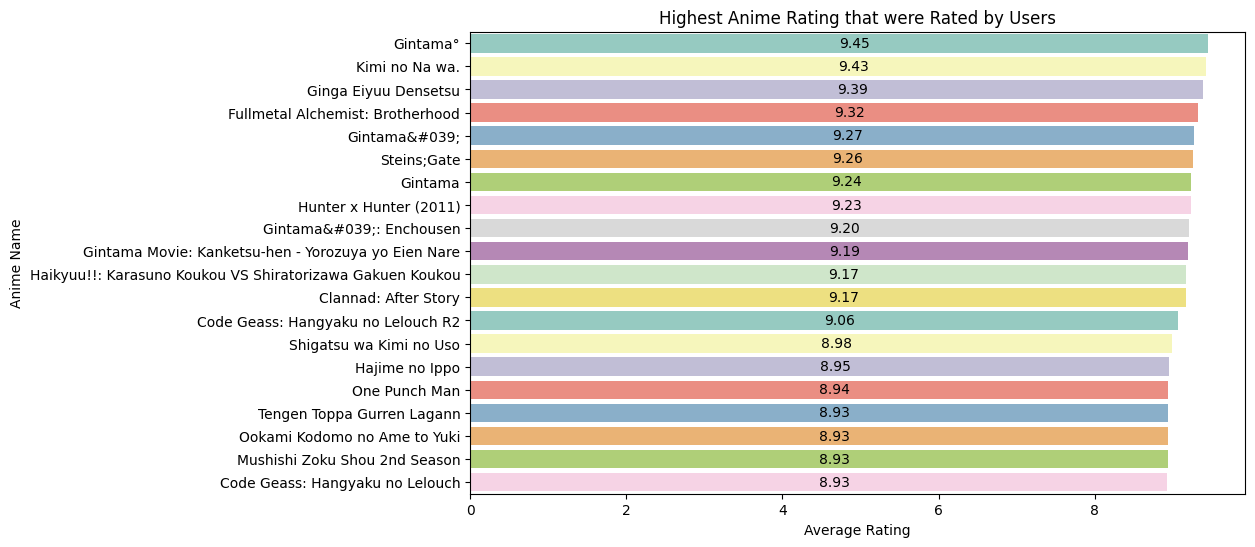

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = df['avg_rating'], y = df['name'], orient = 'h', hue = df['name'], palette = 'Set3')

for index, row in df.iterrows():
    ax.text(x = row['avg_rating'] / 2, y = index, s = f'{row["avg_rating"]:.2f}', va = 'center', ha = 'left', color = 'black')

plt.xlabel('Average Rating')
plt.ylabel('Anime Name')
plt.title('Highest Anime Rating that were Rated by Users')

plt.show()

In [14]:
reader = Reader(sep = ',', rating_scale=(0, 10))
dataset = Dataset.load_from_df(df = rating_df, reader = reader)

train_set, test_set = train_test_split(data = dataset, test_size = 0.2, random_state = 2025, shuffle = True)

type(train_set) , type(test_set) , train_set.all_users() , train_set.all_items(), train_set.n_ratings ,  len(test_set),     train_set.n_ratings + len(test_set)

(surprise.trainset.Trainset,
 list,
 range(0, 68812),
 range(0, 9744),
 5069792,
 1267448,
 6337240)

In [15]:
model = SVD(
    n_factors = 100,
    n_epochs = 20,
    lr_all = 0.005,
    reg_all = 0.01,
    lr_bi = 0.002,
    reg_bi = 0.015,
    biased = True,
    random_state = 2025
)

model.fit(train_set)

In [17]:
predicts = model.test(test_set)

RMSE = accuracy.rmse(predictions = predicts, verbose = False)
MAE = accuracy.mae(predictions = predicts, verbose = False)

print(f'RMSE : {RMSE}')
print(f'MAE  : {MAE}')

RMSE : 1.1683908825924627
MAE  : 0.870380775514337


In [18]:
param_dist = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [10, 20, 30, 40],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.01, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(SVD, param_dist, n_iter= 10, measures=['rmse', 'mae'], refit= False, cv = 2, random_state= 2025, return_train_measures = True)
random_search.fit(dataset)

display(f'Best Parameters : {random_search.best_params}')

best_params = random_search.best_params
print("Best parameters:", best_params)

"Best Parameters : {'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.01}}"

Best parameters: {'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.01}}


In [19]:
best_params = random_search.best_params['rmse']

model_best = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all']
)

In [20]:
model_best.fit(train_set)

In [21]:
predicts = model_best.test(test_set)

RMSE = accuracy.rmse(predictions = predicts, verbose = False)
MAE = accuracy.mae(predictions = predicts, verbose = False)

print(f'RMSE : {RMSE}')
print(f'MAE  : {MAE}')

RMSE : 1.1964101571499064
MAE  : 0.9056828614607567


In [23]:
model_path = "../model_machine_learning/recommendation_ml.pkl"

dump.dump(model_path, algo=model_best)
print("Exported successfully")

Exported successfully
